# TP 2

#### Grupo 4: Aschieri Juan Pablo, Civini Diego Emanuel, Rivero Joaquin, Rovira Rossel Francisco

In [180]:
from math import e, log
import time
from heapq import heappush, heappop
from scipy.stats import poisson
import matplotlib.pyplot as plt
import itertools
import simpy
import numpy as np
import random
from statistics import mean

## Generador de numeros aleatorio del TP1

In [181]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x ^ (self.x << 13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [182]:
class Uniform_generator:
    def __init__(self, seed, scale= 1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [183]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        if self.parameter >=1:
            return log(r) / (-1 * self.parameter)
        else: 
            return -log(1 - r) / self.parameter

    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

descubri que los primeros dos numeros del generador son muy distintos y despues se acomoda. lo de abajo hay que borrarlo  
tambien sospecho que por lo general da media menor que 6 mas seguido que mayor que 6, creo que tienee sentido pero mmm

In [ ]:
seed = int(time.time())

exp_generator = Exp_generator(seed, 1/6)

b = exp_generator.rand()
b = exp_generator.rand()
a = []

for i in range(100):
    n = exp_generator.rand()
    a.append(n)
    if n < 0:
        print(n)

print(a)
print(sum(a)/len(a))

[2.4211548796528986, 0.6882983982479244, 8.331429723908508, 0.756092029146064, 2.0431355866182352, 0.001241201851286486, 2.652679002638808, 6.2645204595399, 2.2684074103750653, 18.039677311093403, 1.8142094107787936, 0.7320627008815334, 8.788592927841163, 0.9884080870613905, 1.3667318526745282, 1.5307562490806743, 9.372743594701413, 7.8539415516096325, 7.1764426859949415, 4.213805854662124, 4.857719593901716, 5.303237123797859, 3.3874972756352757, 3.7595077868975824, 12.792569941408013, 2.4084866899416504, 3.575344193090143, 2.6090544642509856, 6.209572584042339, 2.936406677297113, 5.147233441172684, 0.5924642617763998, 1.7917732790876628, 1.1202186529010387, 1.4422261339772586, 1.208495171706531, 2.585323289303848, 3.492348173390278, 9.36562168100639, 0.14073967575970178, 12.547994600144097, 7.424877894715952, 8.4094935811255, 1.2340523808336321, 16.94939695095941, 3.8508175759070715, 0.7633678207774721, 11.179244576149259, 1.0157873501299841, 6.146902289739327, 14.947143426958357, 1.

## Ejercicio 1

### Programacion tradicional

Definimos un generador de una distribucion de poisson porque lo utilizaremos mas adelante.

In [ ]:
def factorial(n):
    resultado = 1
    for i in range(1, n + 1):
        resultado *= i
    return resultado

def poisson_probability(parameter, i, previous_probability):
    if previous_probability == 0:
        return poisson.pmf(i, parameter)
    return (parameter/i)*previous_probability

class Poisson_generator:
    def __init__(self, seed, parameter):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()

        accumulated_probability = poisson_probability(self.parameter, 0, 0)
        previous_probability = accumulated_probability
        i = 0

        while(accumulated_probability < r):
            i += 1
            previous_probability = poisson_probability(self.parameter, i, previous_probability)
            accumulated_probability += previous_probability

        return i
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Asumimos que el satélite da siempre la misma vuelta al mundo que tarda lo mismo, y que se puede pensar al tiempo en que tarda el satelite en llegar a una posicion a la que puede sacar una foto de la request como una uniforme entre 0 y el tiempo en que tarda en dar la vuelta al mundo, ya que los puntos sobre el globo se distribuyen uniformemente.

Para simular el problema lo que hacemos es definir un delta de tiempo (time step), que sera de cada que intervalo discreto avanzaremos el tiempo de la simulacion. Por cada iteracion generamos un valor de una distribucion de poisson que representa la cantidad de arribos de solicitudes que llegaron en el ultimo intervalo de tiempo. Por cada solicitud de tiempo que halla llegado luego generamos un valor de tiempo con una distribucion uniforme entre 0 y el satelite_perior (tiempo en dar la vuelta al mundo del satelite), que representa el tiempo que tardara el satelite en estar en posicion para poder sacar la foto. Por cada iteracion avanzamos el tiempo de todas las request en la cola, y agregamos las nuevas, ademas de ir anotando datos como cuantas veces hubo cada longitud de cola en todas las iteraciones, y cuanto fue el tiempo para servir a la primera request para cada longitud de cola.

In [ ]:
def simulate_satelite_request_queue_length(time_step, iterations, request_per_unit_time, satelite_period):
    generator_amount_of_request = Poisson_generator(int(time.time()) * 8647359734, request_per_unit_time*time_step)
    generator_time_to_serve = Uniform_generator(int(time.time()) * 345678976, satelite_period)
    simulated_queue = []
    observed_queue_length = {}
    time_to_serve_first_for_queue_length = {}

    for _ in range(iterations):
        advance_time(simulated_queue, time_step)
        get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve)    
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])
            
    return get_frequencies(observed_queue_length, iterations), get_mean_times(time_to_serve_first_for_queue_length)

In [ ]:
def advance_time(simulated_queue, time_step):
    for i in range(len(simulated_queue)):
        simulated_queue[i] -= time_step

    while (len(simulated_queue) != 0 and simulated_queue[0] <= 0):
        item = heappop(simulated_queue)
        #print(f'Se elimino una request de tiempo: {item}')

def get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve):
    amount_of_requests = generator_amount_of_request.rand()
    for request in range(amount_of_requests):
        #por ahora asumimos que el time to serve es uniforme, porque se hacen requests uniformemente alrededor del mundo
        heappush(simulated_queue, generator_time_to_serve.rand())

def get_frequencies(observed_queue_length, iterations):
    #print(f'Entro a get_frequencies con dicc = {observed_queue_length}')
    observed_frequencies = []
    #print(f'El maximo es: {max(observed_queue_length.keys())}')
    for j in range(max(observed_queue_length.keys()) + 1):
        times_observed = observed_queue_length.get(j, 0)
        #print(f'Para {j} se observo {times_observed}')
        observed_frequencies.append(times_observed/iterations)
    return observed_frequencies

def get_mean_times(time_to_serve_for_queue_length):
    mean_times = {}

    for key in time_to_serve_for_queue_length:
        sum_of_times = 0
        for j in time_to_serve_for_queue_length[key]:
            sum_of_times += j
        mean_times[key] = sum_of_times/len(time_to_serve_for_queue_length[key])
    
    return mean_times

Simulamos un ejemplo donde tomamos que el satelite tarde 48 horas en dar la vuelta al mundo, y que llegan 10 requests por dia en promedio. Usamos un intervalo de media hora y realizamos 50 000 horas de simulacion

In [ ]:
frequencies, times_to_serve_first = simulate_satelite_request_queue_length(0.5, 100000, 5/12, 48)

Podemos ver que como en general se acumulan las request hasta llegar al rededor de 10 y luego tiende a disminuir la cantidad que hay

In [ ]:
def satelite_frequencies_graph(frequencies):
    x_axis = list(range(len(frequencies)))
    y_axis = frequencies
    plt.plot(x_axis, y_axis)
    plt.show()

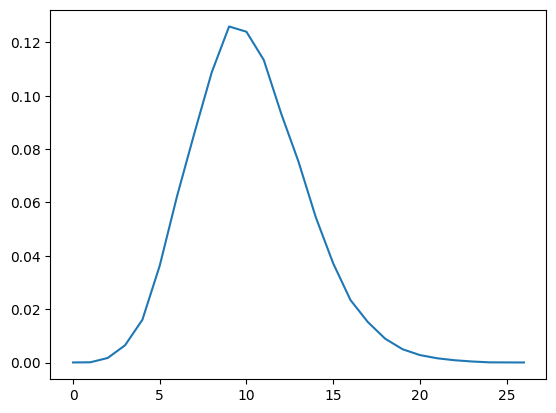

In [ ]:
satelite_frequencies_graph(frequencies)

El paper llegaba a la conclusion de que cuantas mas solicitudes hayan en la cola, el tiempo que se tarda en servir estas request es menor. Para verificar esto miramos el siguiente grafico que muestra el tiempo promedio que tarda el satelite en servir al request mas cercano

In [ ]:
def satelite_times_to_serve_first(times_to_serve_first):
    plt.bar(times_to_serve_first.keys(), times_to_serve_first.values())
    plt.xlabel("Queue length")
    plt.ylabel("Avarege time to serve first request")
    plt.show()

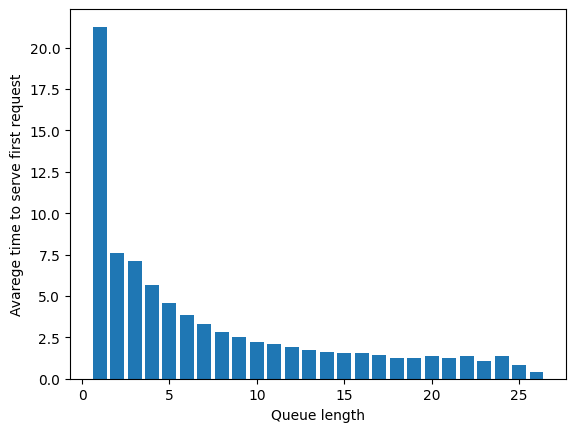

In [ ]:
satelite_times_to_serve_first(times_to_serve_first)

Vemos que en este caso asi sucede, cuantas mas solicitudes hay en la cola menor es el tiempo para tomar la foto. Esto tiene sentido ya que cuantas mas request hayan en espera mas chances habra de que haya alguna mas cercana.
Si bien el grafico solo muestra la primera requet, como esto se modela como un proceso de poisson, por propiedad de perdidad de memoria se puede ver que se cumplira para el tiempo entre todos los arribos. 

### Simpy 

Para realizar la simulacion utilizando simpy vamos a definir dos procesos. Por un lado el satelite_request_generator que va a generar request, cada un lapso de tiempo aleatorio segun una distribucion exponencial de parametro request_per_unit_time. Cada request tiene un tiempo uniforme entre 0 y satellite_period y es pusheada al heap.

In [ ]:
def satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length):
    while True:
        yield env.timeout(time_step)
        advance_time(simulated_queue, time_step) 
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])

In [ ]:
def satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time):
    exp_generator = Exp_generator(int(time.time()) * 324324234, request_per_unit_time)
    uni_generator = Uniform_generator(int(time.time()) * 54735235, satellite_period)
    while True:
        time_for_next_req = exp_generator.rand()
        time_for_image = uni_generator.rand()
        yield env.timeout(time_for_next_req)
        heappush(simulated_queue, time_for_image)
        

In [ ]:
env = simpy.Environment()

simulated_queue = []
observed_queue_length = {}
time_to_serve_first_for_queue_length = {}
satellite_period = 48
request_per_unit_time = 5/12
time_step = 0.5
iterations = 100000
env.process(satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time))
env.process(satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length))
env.run(time_step*iterations)

In [ ]:
frequencies, times_to_serve_first = get_frequencies(observed_queue_length, iterations), get_mean_times(time_to_serve_first_for_queue_length)

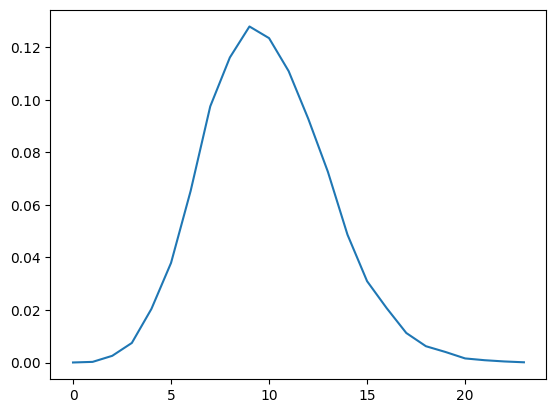

In [ ]:
satelite_frequencies_graph(frequencies)

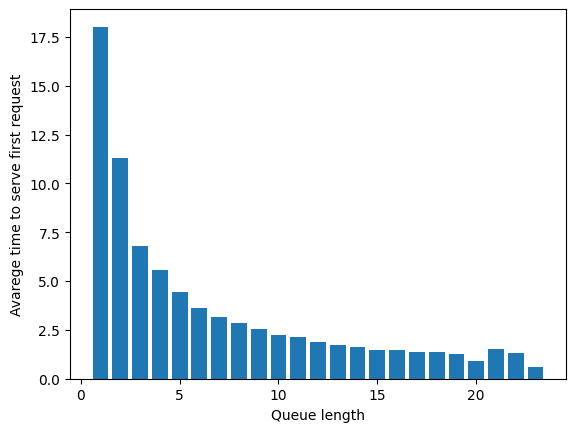

In [ ]:
satelite_times_to_serve_first(times_to_serve_first)

## Ejercicio 2

In [184]:
BUFFER_SIZE = 100
SIM_TIME = 4320 #minutos (3 dias)

- Factor de ocupación del sistema. (listo)
- Cantidad media de solicitudes en el buffer (listo)
- Cantidad media de solicitudes en el sistema (listo)
- Tiempo medio que las solicitudes están en el buffer (listo)
- Tiempo medio de solicitudes en el sistema (listo)
- Determinar el tamaña del buffer para que la probabilidad de que haya lugar para recibir solicitudes sea
como mucho 3%.
- Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo
de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?

De esta manera cada maquina es un proceso y desp hay otro proceso que se encarga de llenar las lista con requests para que cada maquina vaya desencolando 
y procesando requests

In [185]:
class Machine:
    
    def __init__(self,id):
        self.working_time = 0
        self.requests_taken = 0
        self.id = id
        self.req_time_stats = []
    
    def process_request(self, request):
        self.requests_taken += 1
        self.working_time += request

    def add_req_time_stat(self, time_tup):
        # The tuple has the following format: (req_buffer_time, req_system_time, req_finish_time)
        self.req_time_stats.append(time_tup)


In [207]:
"""
Con esta implementacion, las maquinas chequean que haya requests en la cola cada 1 seg. Osea, que si la cola estaa vacia, la maquina cada 1 seg va a 
chequear si llego un nuevo mensaje. Ver con los chicos si estan de acuerdo con esto (o tamb preguntar al de la practica). Porque otro caso que CREO que se puede
hacer es que apenas llegue un request, la maquina ya sepa y lo empieze a procesar all instante.
Tambien ver que onda el arrribo de mensajes, estan llegando cada mucho tiempo y los procesa re rapido entonces la cola siempre esta vacia
"""
def request_generator(env, requests_center, requests_buffer, seed):
    """Las solicitudes llegan siguiendo un proceso Poisson con una frecuencia media de 10
    por minuto. Por ende el tiempo entre 2 solicitudes consecutivas seguira una distribucion
    Exponencial de paremtro 10."""
    exponential_gen = Exp_generator(seed, 10) 
    
    print("Requests start to arrive")
    for i in itertools.count():
        time_for_next_request = exponential_gen.rand()
        #time_for_next_request = np.random.exponential(6) # El parametro en esta lib tiene que ser b=1/lambda

        print(f"The next request will arrive in {time_for_next_request}, we are at {env.now}")
        yield env.timeout(time_for_next_request)
        with requests_center.request() as req:
            yield req
            if len(requests_buffer.items) == BUFFER_SIZE:
                print(f"The buffer is full and cannot accept more requests. This requests has been dropped at time {env.now}")
            else:
                print(f"A request arrived and was buffered at time {env.now}")
                yield requests_buffer.put(env.now)
    print("Requests will stop to arrive")


In [209]:
def processing_machine(env, requests_center, requests_buffer, seed, machine):
    exponential_gen = Exp_generator(seed, 6)
    print(f"The machine {machine.id} starts.")
    while True:
        
        time_to_process = 0.001
        request_processed = False
        #print(f"Machine {machine.id} will try to process a request at {env.now}")
        with requests_center.request() as req:
            yield req
            
            if len(requests_buffer.items) != 0:
                print(f"A request is starting to be processed by machine {machine.id} at {env.now}")
                arrival_time = yield requests_buffer.get()
                print(arrival_time)
                buffer_time = env.now - arrival_time
                print(f"La cantidad de requests en el buffer es {len(requests_buffer.items)}")
                time_to_process = exponential_gen.rand()
                #time_to_process = np.random.exponential(10)
                machine.process_request(time_to_process)
                print(f"Machine {machine.id} will finish at {time_to_process + env.now}")
                request_processed = True
                
        # If there are no requests to process in the buffer, the timeout is of 0 seconds.
        yield env.timeout(time_to_process)
        if request_processed:
            system_time = env.now - arrival_time
            finish_time = arrival_time + system_time
            time_tup = (buffer_time, system_time, finish_time)
            machine.add_req_time_stat(time_tup)
            print(f"Machine {machine.id} has finished processing the request at {env.now}")

SyntaxError: invalid syntax (1811932659.py, line 3)

In [188]:
def buffer_stats(env, buffer, amount):
    while True:
        amount.append(len(buffer.items))
        yield env.timeout(1)

podemos usar nuestro generador, ronda cantidad de llegadas 11/12 en el primer minuto (empiricamente), varias veces se pasa y muy pocas veces de menos, el otro es mas uniforme, puede dar 8 o 13.  
voy a dejar el otro por ahora

In [194]:
env = simpy.Environment()
init = env.now
requests_center = simpy.Resource(env, 1)
requests_buffer = simpy.Store(env, BUFFER_SIZE)
env.process(request_generator(env, requests_center, requests_buffer, int(time.time())))

amount = []
machine_1 = Machine(1)
machine_2 = Machine(2)
env.process(buffer_stats(env, requests_buffer, amount))
env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), machine_1))
env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), machine_2))

env.run(until=SIM_TIME)

end = env.now

Requests start to arrive
The next request will arrive in 4.874540428507905, we are at 0
The machine 1 starts.
The machine 2 starts.
A request arrived and was buffered at time 4.874540428507905
The next request will arrive in 5.697846038997622, we are at 4.874540428507905
A request is starting to be processed by machine 1 at 4.874999999999963
4.874540428507905
La cantidad de requests en el buffer es 0
Machine 1 will finish at 12.999234047513136
A request arrived and was buffered at time 10.572386467505527
The next request will arrive in 2.3188262503834234, we are at 10.572386467505527
A request is starting to be processed by machine 2 at 10.57299999999958
10.572386467505527
La cantidad de requests en el buffer es 0
Machine 2 will finish at 18.69723404751275
A request arrived and was buffered at time 12.891212717888951
The next request will arrive in 0.7132988558291768, we are at 12.891212717888951
Machine 1 has finished processing the request at 12.999234047513136
A request is starting 

Ocupation factor con una maquina

In [195]:
m1_ocupation_factor = machine_1.working_time/SIM_TIME
m2_ocupation_factor = machine_2.working_time/SIM_TIME
print(f"machine 1 ocupation_factor: {m1_ocupation_factor}")
print(f"machine 2 ocupation_factor: {m2_ocupation_factor}")


machine 1 ocupation_factor: 0.8364346096912468
machine 2 ocupation_factor: 0.8286780735372263


Ocupation factor con dos maquinas

In [196]:
ocupation_factor = (machine_1.working_time + machine_2.working_time)/(SIM_TIME*2)
print(f"ocupation_factor: {ocupation_factor}")

ocupation_factor: 0.8325563416142366


Cantidad media de elementos en el buffer: a cada segundo mido la cantidad de elementos en el buffer, luego divido la suma por la cantidad total de mediciones

In [197]:
cant = 0
for i in amount:
    cant += i

cant = cant/len(amount)
print(f"cantidad media de elementos en el buffer: {cant}")  

cantidad media de elementos en el buffer: 4.897222222222222


Calculamos la cantidad media de solicitudes en el sistema

In [198]:
total_req_time_stats = machine_1.req_time_stats + machine_2.req_time_stats

req_quantity = []
for second in range(SIM_TIME):
    interval_req_quantity = 0
    for time_tup in total_req_time_stats:
        finish_time = time_tup[2]
        arrival_time = finish_time - time_tup[1] # finish_time - system_time
        if arrival_time < second < finish_time:
            """ 
            If the second we are checking is between the finish time and arrival time
            it means that the request was living on the system at that second.
            """
            interval_req_quantity += 1
    req_quantity.append(interval_req_quantity)
print(req_quantity)
print("cantidad media de elementos en el sistema: ",mean(req_quantity))


    
    

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 5, 5, 5, 4, 4, 4, 6, 5, 5, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 12, 12, 13, 13, 13, 13, 13, 13, 12, 12, 12, 11, 11, 11, 11, 11, 10, 9, 8, 7, 8, 7, 6, 6, 6, 6, 6, 4, 4, 3, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 3, 3,

## EJERCICIO 3

In [199]:
SIM_TIME_3 = 30 * 24

### Primera version

In [200]:
class Truck:

    def __init__(self, env, id, arrival_time):
        self.env = env
        self.id = id
        self.arrival_time = arrival_time
        self.download_shipment_time = None
        self.finish_time = None


    def download_shipment(self, distribution_center, exp_generator):
        
        with distribution_center.request() as req:
            yield req
            self.download_shipment_time = env.now
            time_to_download = exp_generator.rand()
            
            yield env.timeout(time_to_download)
        self.finish_time = env.now
            

def truck_generator(env, distribution_center, seed, trucks, type, trucks_per_unit_time):
    arraival_time_generator = Exp_generator(seed, trucks_per_unit_time)
    if type == 'barcode':
        download_time_generator = Exp_generator(int(time.time()) * 345783456, 2)
    else:
        download_time_generator = Exp_generator(int(time.time()) * 345783456, 12/5)

    for i in itertools.count():
        time_for_next_truck = arraival_time_generator.rand()
        yield env.timeout(time_for_next_truck)
        
        truck = Truck(env, i, env.now)
        env.process(truck.download_shipment(distribution_center, download_time_generator))
        trucks.append(truck)



### Segunda version

Escenario en el que se usa codigo de barras para descargar y hay 4 darsenas

In [201]:
env = simpy.Environment()
distribution_center = simpy.Resource(env, 4)

trucks = []
env.process(truck_generator(env, distribution_center, int(time.time()) * 235462324, trucks, 'barcode', 5))
env.run(SIM_TIME_3)

Estadísticas:
-  Simular ambos escenarios utilizando Simpy o programación tradicional.
-  Cantidad media de camiones en el sistema (listo)
-  Cantidad media de camiones en cola (listo)
-  Tiempo medio de camiones en el sistema (listo)
-  Tiempo medio de camiones en cola (listo)
-  Qué recomendación se puede hacer sobre el cierre de la dársena propuesto

In [202]:
# We cheack for every second how many trucks were in the system, buffer, their times, etc.
system_quantity = []
buffer_quantity = []
trucks_time_stats = []
curr_time = 0
while curr_time < SIM_TIME_3:
    trucks_in_system = 0
    trucks_in_buffer = 0
    for truck in trucks:
        #if curr_time < 20:
        #    print(f"arrival_time: {truck.arrival_time}      truck.download_shipment_time: {truck.download_shipment_time}      truck.finish_time: {truck.finish_time}")
        if not all([truck.download_shipment_time,truck.finish_time]):
            # If the truck never got out of the buffer or system before the simulation ended, their times cannot be taken into account
            continue

        if truck.arrival_time < curr_time < truck.finish_time:
            trucks_in_system += 1

        if truck.arrival_time < curr_time < truck.download_shipment_time:
            trucks_in_buffer += 1
    system_quantity.append(trucks_in_system)
    buffer_quantity.append(trucks_in_buffer)
    curr_time += 0.2

trucks_system_time = [truck.finish_time - truck.arrival_time for truck in trucks if all([truck.download_shipment_time,truck.finish_time])]
trucks_buffer_time = [truck.download_shipment_time - truck.arrival_time for truck in trucks if all([truck.download_shipment_time,truck.finish_time])]

print(mean(system_quantity))
print(mean(buffer_quantity))
print(mean(trucks_system_time))
print(mean(trucks_buffer_time))
print(buffer_quantity)

2.9255555555555555
0.49166666666666664
0.6049468909156182
0.10141393176996334
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 3, 3, 2, 1, 3, 4, 6, 7, 6, 6, 6, 6, 4, 4, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 3, 3, 3, 2, 3, 4, 3, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 7, 4, 2, 4, 

Escenario en el que se usa RFID para descargar y hay 3 darsenas

In [203]:
def run_simulation(seed):

    random.seed(seed)

    env = simpy.Environment()
    distribution_center = simpy.Resource(env, 4)

    trucks = []
    env.process(truck_generator(env, distribution_center, int(time.time()), trucks, 'rfid'))

    env.run(2000)


    buffer_quantity = []
    for second in range(2000):
        trucks_in_buffer = 0
        for truck in trucks:
            if not all([truck.download_shipment_time,truck.finish_time]):
                # If the truck neever got out of the buffer or system before the simulation ended, their times cannot be taken into account.
                continue
            if truck.arrival_time < second < truck.download_shipment_time:
                trucks_in_buffer += 1
        buffer_quantity.append(trucks_in_buffer)
    print(buffer_quantity)
    return mean(buffer_quantity)

#def get_trucks_in_buffer_mean(trucks):
#    buffer_quantity = []
#    for second in range(2000):
#        trucks_in_buffer = 0
#        for truck in trucks:
#            print(f'{truck.arrival_time}    -    {truck.download_shipment_time}')
#            if not all([truck.download_shipment_time,truck.finish_time]):
#                # If the truck neever got out of the buffer or system before the simulation ended, their times cannot be taken into account.
#                continue
#            if truck.arrival_time < second < truck.download_shipment_time:
#                trucks_in_buffer += 1
#        buffer_quantity.append(trucks_in_buffer)
#
#    print(buffer_quantity)
#    return mean(buffer_quantity)

# NOSE PORQ ESTA FUNCION NO FUNCA, EL M QUE ME DEVUELVE run_simulation es siempre 0
def rfid_analysis():
    uniform_gen = Uniform_generator(int(time.time()))
    mean_vector = []
    for _ in range(2):
        seed = uniform_gen.rand()
        m = run_simulation(seed)
        #print(len(trucks))
        #m = get_trucks_in_buffer_mean(trucks)
        print(m)
        mean_vector.append(m)
    
    plt.hist(mean_vector)
    plt.show()
    
    return mean_vector

In [204]:
l = rfid_analysis()

TypeError: truck_generator() missing 1 required positional argument: 'trucks_per_unit_time'

In [ ]:
random.seed(22)

env = simpy.Environment()
distribution_center = simpy.Resource(env, 4)

trucks = []
env.process(truck_generator(env, distribution_center, int(time.time()), trucks, 'rfid'))

env.run(2000)


buffer_quantity = []
for second in range(2000 * 60):
    trucks_in_buffer = 0
    for truck in trucks:
        if not all([truck.download_shipment_time,truck.finish_time]):
            # If the truck neever got out of the buffer or system before the simulation ended, their times cannot be taken into account.
            continue
        if truck.arrival_time < second < truck.download_shipment_time:
            trucks_in_buffer += 1
    buffer_quantity.append(trucks_in_buffer)

mean(buffer_quantity)

0.0496

In [ ]:
gen=Exp_generator(int(time.time()) * 1234124124124, 5)


In [ ]:
l = gen.get_n_rand(10000)
gen_py = np.random.exponential(1/5, 1000)
mean(l)
#mean(gen_py)


0.19936970900946546

In [ ]:
uni_gen = Uniform_generator(int(time.time()) * 1234124124124)

0.5050601152759185

0.20124103295727283


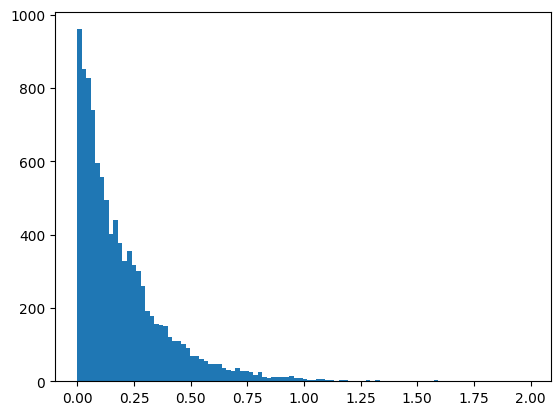

In [ ]:
l = gen.get_n_rand(10000)
print(mean(l))
plt.hist(l, bins = 100)
plt.show()